# Cardinality matching

Cardinality matching is the process of finding the size of the largest subset $\hat{P}$ of a pool of patient $P$ within some "distance" of a given target population:

\begin{equation}
\begin{aligned}
& \underset{\hat{P}}{\text{maximize}}
& & |\hat{P}| \\
& \text{subject to}
& & |\mu_{\hat{P},k} - \mu_{T,k}| \leq \delta \textrm{ for all }k
\end{aligned}
\end{equation}

where $k$ indexes the covariates of $P$ and $T$. In cardinality matching, at least as implemented here, we search only for the size of the largest subset.
Then in a second step, we optimize the balance (distance) among all subsets of the determined size.

In [1]:
import logging
logging.basicConfig(level='INFO')

In [2]:
from pybalance.utils.balance_calculators import *
from pybalance.utils import MatchingData
from pybalance.sim import generate_toy_dataset, load_paper_dataset
from pybalance.lp import ConstraintSatisfactionMatcher
from pybalance.visualization import *

In [3]:
m = generate_toy_dataset(n_pool=15000, n_target=1000)
m

,age,height,weight,gender,haircolor,country,population,binary_0,binary_1,binary_2,binary_3,patient_id
0,62.731988,130.816972,76.100401,0.0,0,4,pool,0,0,0,1,0
1,26.403338,130.784188,80.134423,1.0,1,2,pool,0,0,0,1,1
2,58.155044,175.704961,90.806745,0.0,1,4,pool,0,0,0,0,2
3,68.334248,167.485984,90.081777,0.0,0,4,pool,0,0,0,1,3
4,54.114518,130.782073,53.612174,1.0,1,1,pool,0,1,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
995,21.474205,168.602546,70.342128,0.0,2,5,target,0,0,0,1,15995
996,40.643320,188.188724,61.611744,0.0,2,4,target,1,0,0,1,15996
997,29.472765,161.408162,57.214095,0.0,0,1,target,0,1,1,1,15997
998,41.291949,150.968833,91.270798,0.0,0,3,target,0,0,0,0,15998


## Optimize pool size with balance constraint

In [4]:
# Note that by default, gamma uses the standardized mean difference 
# to calculate distance. The ConstraintSatisfactionMatcher, however,
# can only optimize linear objectives. It is not an error to pass 
# gamma with standardized_difference=True, at this is only affects
# reporting, but to make the reporting consistent with what we're 
# optimizing, we explicitly pass standardized_difference=False here.

gamma = GammaBalance(m, standardize_difference=False)
matcher = ConstraintSatisfactionMatcher(
    matching_data=m, 
    objective=gamma,
    max_mismatch=0.05,
    time_limit=600
)
match_card = matcher.match()

INFO:pybalance.utils.preprocess:Discretized age with bins [18.02, 27.51, 37.01, 46.51, 56.0, 65.5, 75.0].
INFO:pybalance.utils.preprocess:Discretized height with bins [125.0, 136.67, 148.33, 159.99, 171.66, 183.32, 194.99].
INFO:pybalance.utils.preprocess:Discretized weight with bins [50.01, 61.67, 73.34, 85.0, 96.67, 108.33, 120.0].
INFO:pybalance.lp.matcher:Scaling features by factor 200.00 in order to use integer solver with <= 0.0000% loss.
INFO:pybalance.lp.matcher:Solving for match population with pool size = None and target size = 1000 subject to 0.05 balance constraint.
INFO:pybalance.lp.matcher:Matching on 27 dimensions ...
INFO:pybalance.lp.matcher:Building model variables and constraints ...
INFO:pybalance.lp.matcher:Calculating bounds on feature variables ...
INFO:pybalance.lp.matcher:Applying size constraints on pool and target ...
INFO:pybalance.lp.matcher:Solving with 4 workers ...
INFO:pybalance.lp.matcher:Initial balance score: 0.1236
INFO:pybalance.lp.matcher:========

Note that as the optimization progresses, the size of the matched population increases and the balance also increases. This will generally be the case, since it is harder to find a larger set of patients (they have more degrees of freedom) that match a given target. Increased mismatch is the tradeoff of having a larger matched population.

Let's check that the found solution satisfies the balance constraint:

In [5]:
gamma.per_feature_loss(match_card.get_population('pool')).max()

tensor(0.0500)

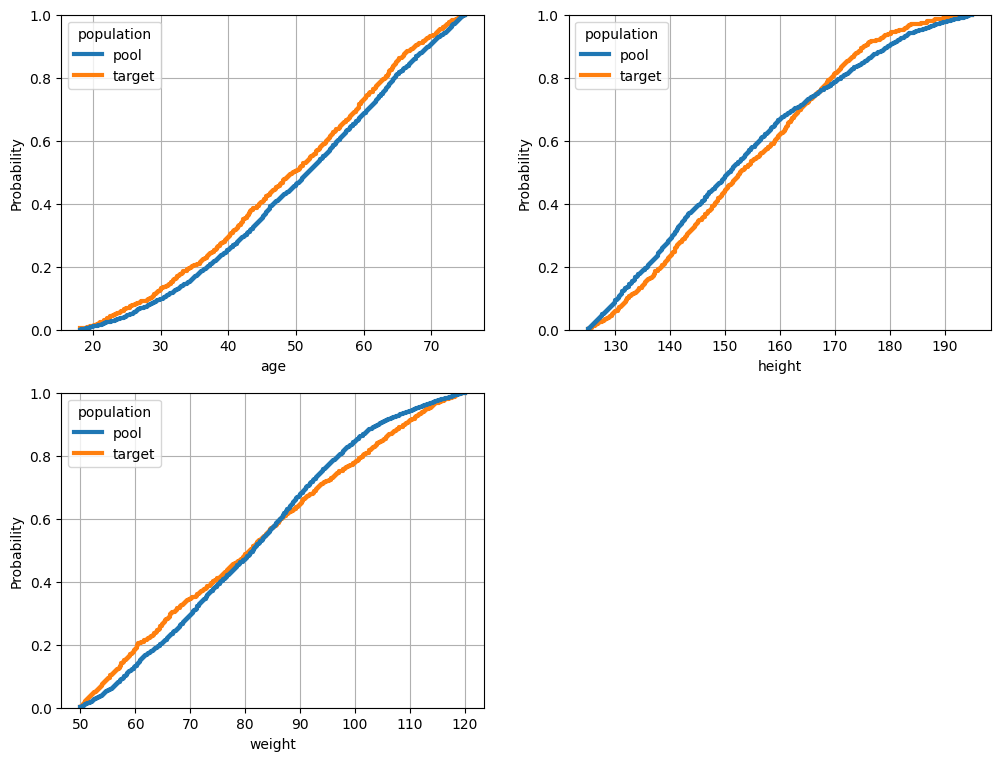

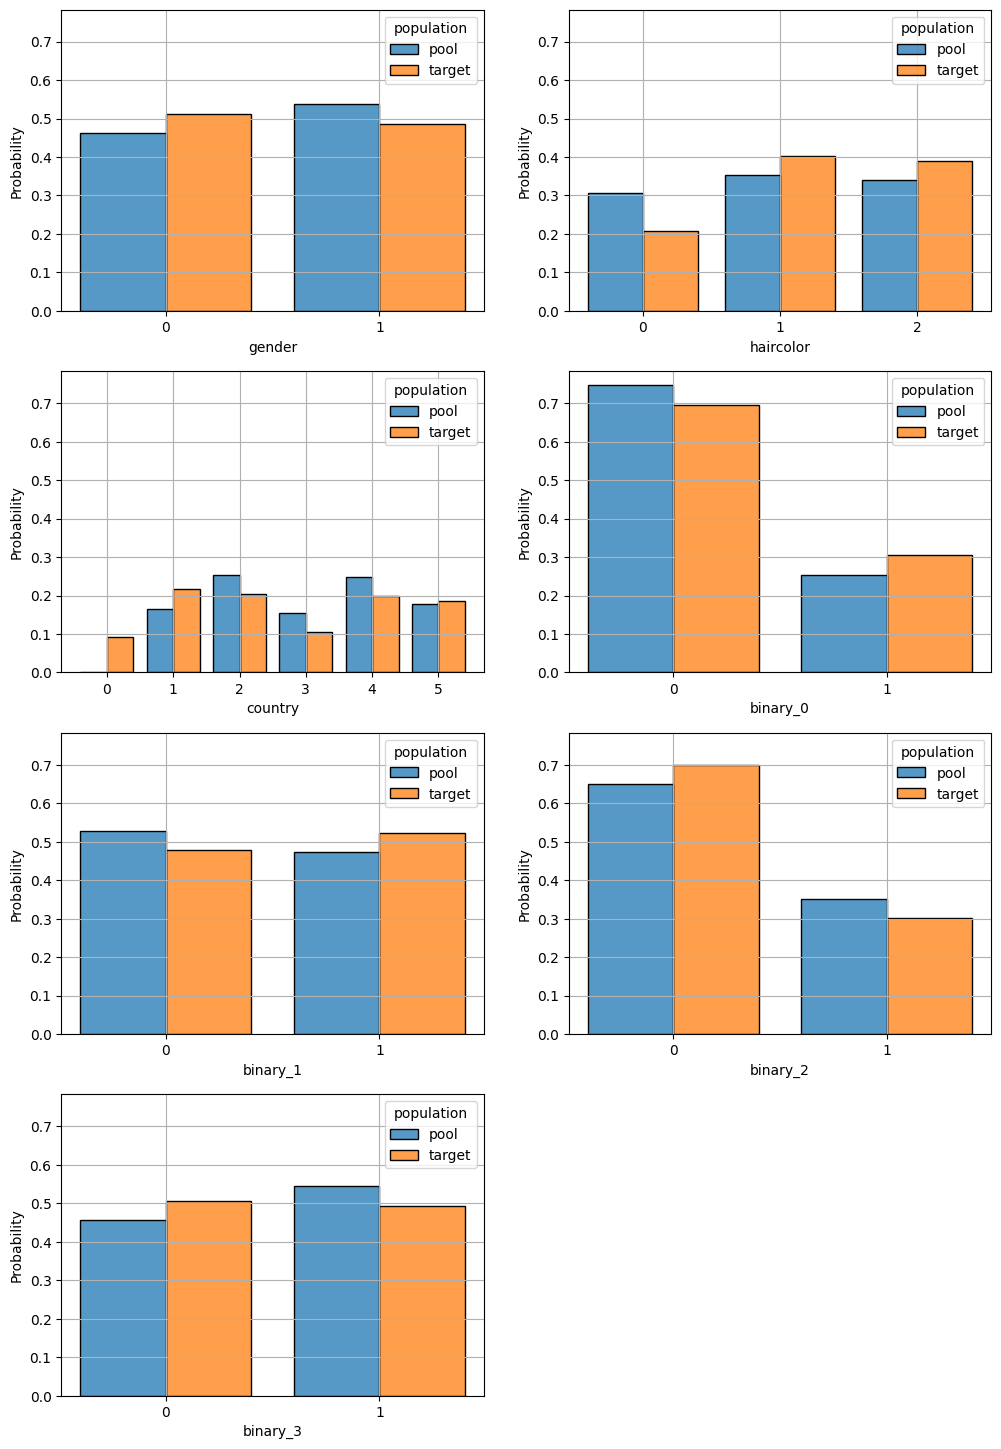

In [6]:
%matplotlib inline
fig = plot_numeric_features(match_card)
fig = plot_categoric_features(match_card)

## Optimize balance with size and balance constraints

Now that we have determined the optimal size of the matched population, let's optimize the balance for all subsets of that size. For this, we create a second matcher object, setting size constraints and keeping the balance constraint (max_mismatch).

In [7]:
matcher = ConstraintSatisfactionMatcher(
    matching_data=m, 
    objective=gamma, 
    max_mismatch=0.05, 
    pool_size=len(match_card.get_population('pool')),
    target_size=len(match_card.get_population('target')),
    time_limit=600
)
match_dist = matcher.match()

INFO:pybalance.lp.matcher:Scaling features by factor 200.00 in order to use integer solver with <= 0.0000% loss.
INFO:pybalance.lp.matcher:Solving for match population with pool size = 4182 and target size = 1000 subject to 0.05 balance constraint.
INFO:pybalance.lp.matcher:Matching on 27 dimensions ...
INFO:pybalance.lp.matcher:Building model variables and constraints ...
INFO:pybalance.lp.matcher:Calculating bounds on feature variables ...
INFO:pybalance.lp.matcher:Applying size constraints on pool and target ...
INFO:pybalance.lp.matcher:Solving with 4 workers ...
INFO:pybalance.lp.matcher:Initial balance score: 0.1236
INFO:pybalance.lp.matcher:=========================================
INFO:pybalance.lp.matcher:Solution 1, time = 0.29 m
INFO:pybalance.lp.matcher:Objective:	825443200.0
INFO:pybalance.lp.matcher:Balance (gamma):	0.0366
INFO:pybalance.lp.matcher:Patients (pool):	4182
INFO:pybalance.lp.matcher:Patients (target):	1000
INFO:pybalance.lp.matcher: 
INFO:pybalance.lp.matcher

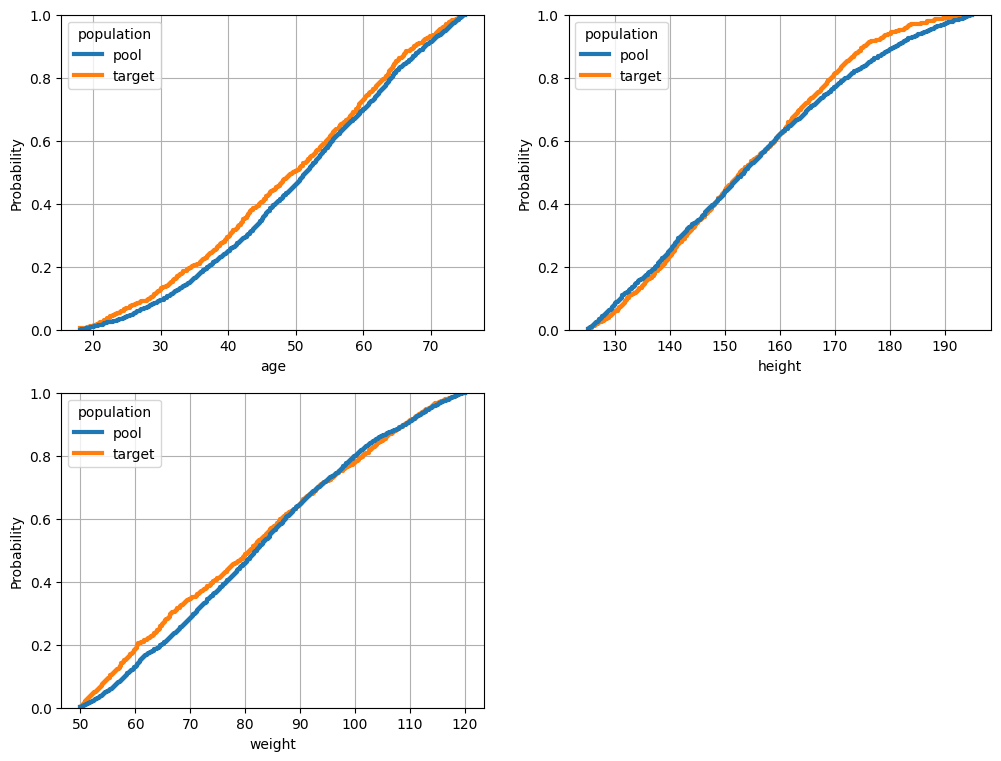

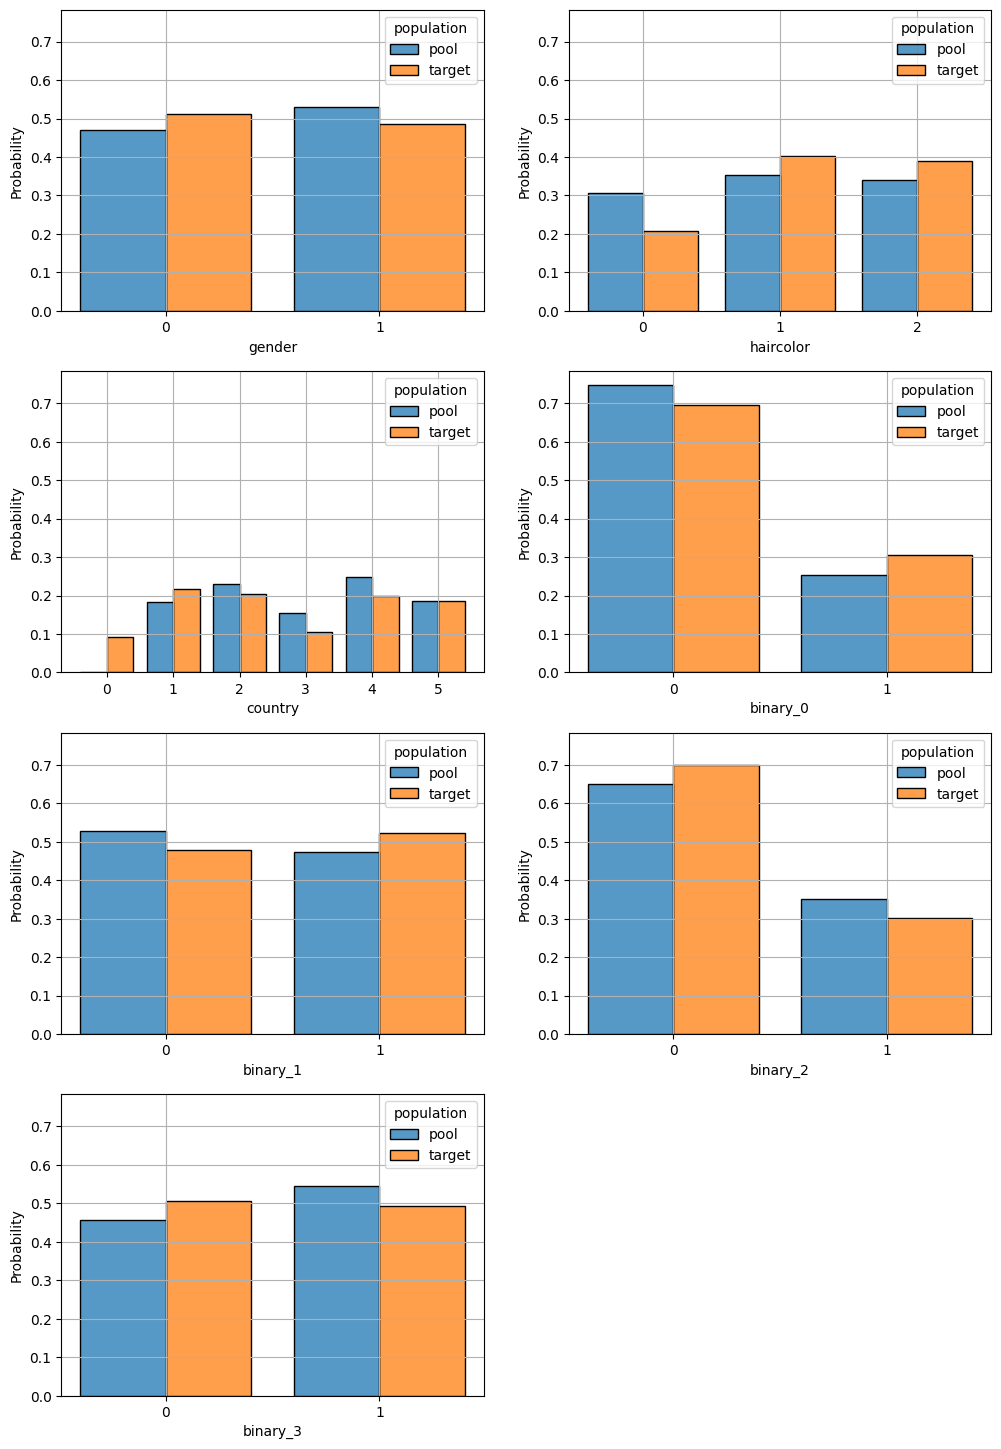

In [8]:
%matplotlib inline
fig = plot_numeric_features(match_dist)
fig = plot_categoric_features(match_dist)

## Optimize balance without balance constraint

You can also remove the balance constraint, if you don't care about individual mismatched features. Here we run a matcher fixed to the size of the optimal subset size but relax the mismatch constraint.

In [9]:
matcher = ConstraintSatisfactionMatcher(
    matching_data=m, 
    objective=gamma, 
    pool_size=len(match_card.get_population('pool')),
    target_size=len(match_card.get_population('target')),
    time_limit=600
)
match_dist2 = matcher.match()

INFO:pybalance.lp.matcher:Scaling features by factor 200.00 in order to use integer solver with <= 0.0000% loss.
INFO:pybalance.lp.matcher:Solving for match population with pool size = 4182 and target size = 1000 subject to None balance constraint.
INFO:pybalance.lp.matcher:Matching on 27 dimensions ...
INFO:pybalance.lp.matcher:Building model variables and constraints ...
INFO:pybalance.lp.matcher:Calculating bounds on feature variables ...
INFO:pybalance.lp.matcher:Applying size constraints on pool and target ...
INFO:pybalance.lp.matcher:Solving with 4 workers ...
INFO:pybalance.lp.matcher:Initial balance score: 0.1236
INFO:pybalance.lp.matcher:=========================================
INFO:pybalance.lp.matcher:Solution 1, time = 0.07 m
INFO:pybalance.lp.matcher:Objective:	2127925600.0
INFO:pybalance.lp.matcher:Balance (gamma):	0.0942
INFO:pybalance.lp.matcher:Patients (pool):	4182
INFO:pybalance.lp.matcher:Patients (target):	1000
INFO:pybalance.lp.matcher: 
INFO:pybalance.lp.matche

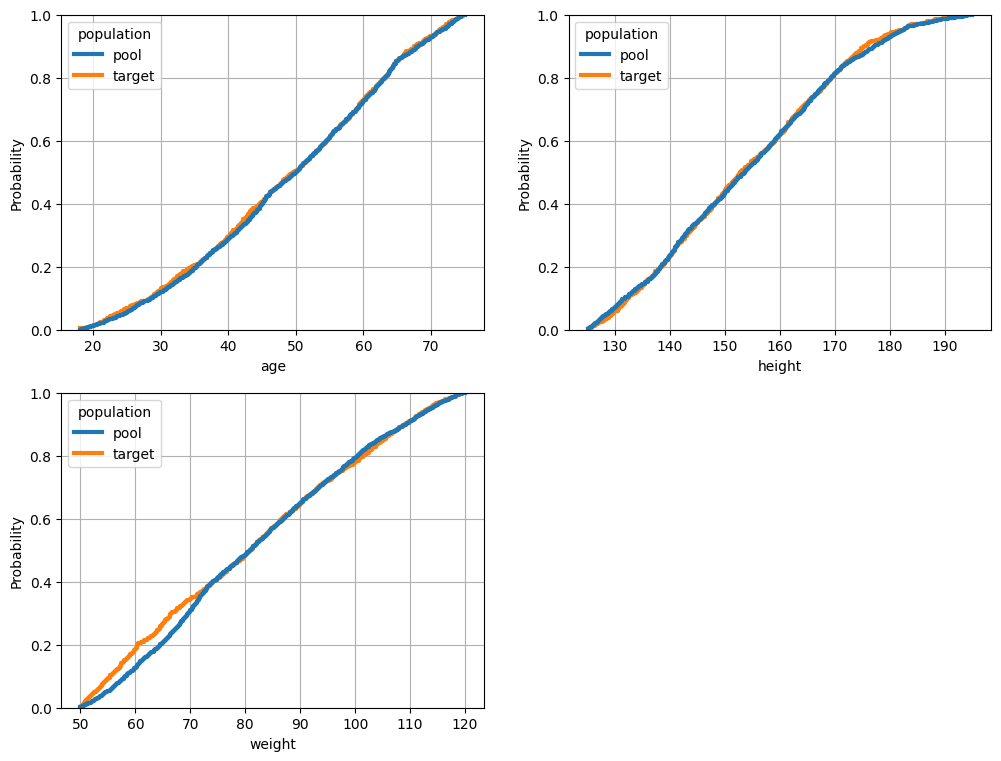

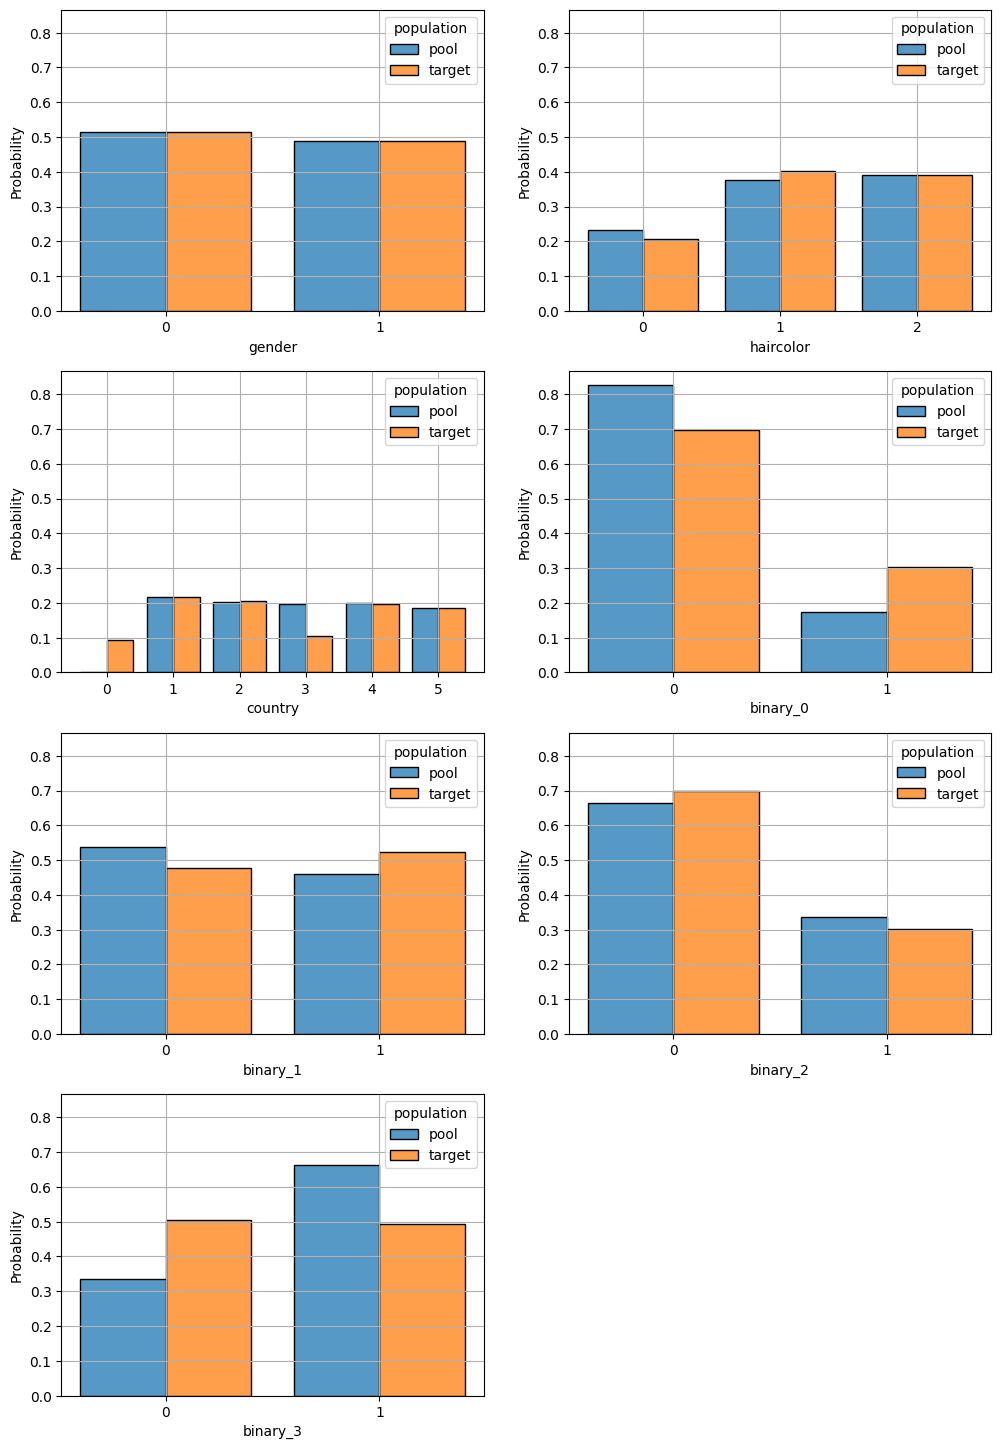

In [10]:
%matplotlib inline
fig = plot_numeric_features(match_dist2)
fig = plot_categoric_features(match_dist2)

Note that the solution no longer satisfies the max_mismatch constraint.

In [11]:
gamma.per_feature_loss(match_dist2.get_population('pool')).max()

tensor(0.1696)